In [1]:
import torch, time, copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.quantization import prepare, convert
from src.utils import *
from src.override_resnet import *


class HistSaverPerObserver(object):

    def __init__(
        self, name:str, hist: torch.Tensor, max_val: torch.Tensor, min_val: torch.Tensor
    ):
        assert len(hist) != 0
        self.name = name
        self.hist = hist
        self.max_val = max_val
        self.min_val = min_val
        self.bin = len(hist)

    def save(self, hist):
        self.hist.append(hist)

    def printinfo(self):
        print(f"min: {self.min_val}, max: {self.max_val}, bin: {self.bin}")

    def showhist(self, downsampling_rate=0):
        copy_hist = copy.deepcopy(self.hist)
        if downsampling_rate > 0:
            for i in range(len(copy_hist)):
                if i % downsampling_rate == 0:
                    copy_hist[i : i + downsampling_rate - 1].numel()
                    # print(i, i + downsampling_rate-1)

            copy_hist = copy_hist[0::downsampling_rate]

        # method 1
        plt.scatter(range(len(copy_hist)), copy_hist, s=0.3)
        print(f"len : {len(copy_hist)}")

        # plt.hist
        plt.title(self.name)
        plt.yscale("log")
        plt.xlabel("Activation value")
        # plt.xticks(np.arange(0, self.max_val, step=100))
        plt.ylabel("Frequency")
        plt.show()

    # def find_n_percentile(self, n):
    #     total = torch.sum(self.hist).item()
    #     cSum = torch.cumsum(self.hist, dim=0)
    #     print(f"total: {total}")
    #     print(f"n: {n}")
    #     print(f"cSum: {cSum}")
    #     return

In [2]:


model = resnet50_quan(weights=pretrained_weights_mapping[50])
model.to("cuda")
model.eval()

# set fuse ############################################################
model = fuse_ALL(model)

for name, module in model.named_modules():
    if len(name) > 2 and name[-7:] == "through":

        module.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.HistogramObserver.with_args(
                dtype=torch.quint8,bins=4096, reduce_range=True
            ),
            weight=None,
        )
        print(f"{name} | {module.qconfig}")
        break


prepare(model, inplace=True)

# calibrate the model ############################################################
criterion = nn.CrossEntropyLoss()
train_loader, _ = GetDataset(
    dataset_name="ImageNet",
    device="cuda",
    root="data",
    batch_size=256,
    num_workers=8,
)

layer1.0.through | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, dtype=torch.quint8, bins=4096, reduce_range=True){}, weight=None)


/home/lee/miniconda3/envs/py312/lib/python3.12/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [3]:
num_of_iter = 1
print(SingleEpochEval(model, train_loader, criterion, "cuda", num_of_iter))

# for name, module in model.named_modules():
#     print(name, module)
ListOfHistSaverPerObserver = list()
for name, module in model.named_modules():
    if (
        len(name) > 2
        and name[-7:] == "through"
        and hasattr(module, "activation_post_process")
    ):
        print(f"{name}")
        ListOfHistSaverPerObserver.append(
            HistSaverPerObserver(
                name=name,
                hist=module.activation_post_process.histogram.to("cpu"),
                max_val=module.activation_post_process.max_val.to("cpu"),
                min_val=module.activation_post_process.min_val.to("cpu"),
            )
        )
        break

  0%|          | 1/5005 [00:03<5:27:46,  3.93s/it]

(0.9676284193992615, 91.015625)
layer1.0.through


min: 0.0, max: 33.28083419799805, bin: 4096
len : 4096


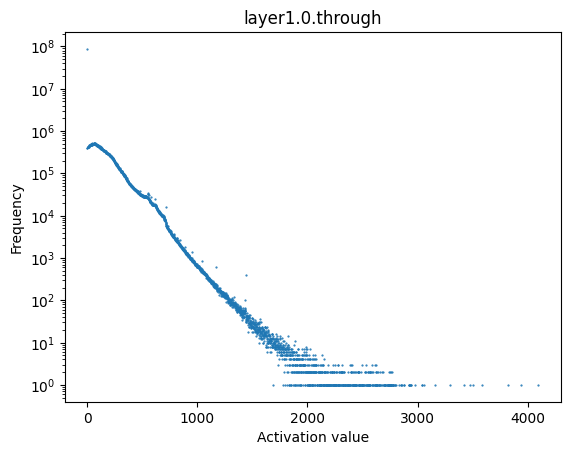

In [4]:
ListOfHistSaverPerObserver[-1].printinfo()

ListOfHistSaverPerObserver[-1].showhist(downsampling_rate=1)


In [5]:
_hist = ListOfHistSaverPerObserver[-1].hist
print(len(_hist))

total = torch.sum(_hist).item()
cSum = torch.cumsum(_hist, dim=0)
print(f"total: {total}")
print(f"cSum: {cSum}, {cSum.shape}")

4096
total: 205520880.0
cSum: tensor([8.7295e+07, 8.7698e+07, 8.8102e+07,  ..., 2.0552e+08, 2.0552e+08,
        2.0552e+08]), torch.Size([4096])


In [7]:
for i in range(len(cSum)):
    if cSum[i].item() > total * 0.9525:
        print(i)
        break
for i in range(len(cSum)):
    if cSum[i].item() > total * 0.99:
        print(i)
        break
for i in range(len(cSum)):
    if cSum[i].item() > total * 0.999:
        print(i)
        break
for i in range(len(cSum)):
    if cSum[i].item() > total * 0.9999:
        print(i)
        break
for i in range(len(cSum)):
    if cSum[i].item() > total * 0.99999:
        print(i)
        break

379
608
893
1269
1715
